### Modules used in this notebook
`xarray`, `numpy`, `cfgrib`, `regionmask`, `matplotlib`

# C.005: how to apply a mask (country mask, weighted mask)

Load the packages

In [5]:
import numpy as np
import cfgrib
import xarray as xr # xarray library access and manipulate multi-dimensional data (such as netcdf). With the cfgrib engine we can manipulate grib files
import regionmask # regionmask helps create of geographical regions.
from matplotlib import pyplot as plt # matplotlib package provides different functions to plot data

We use xarray to open the dataset

In [6]:

ds = xr.open_dataset('..\data\era5-u100_v100_201903.grib')
ds = ds.assign({'ws100': (ds['u100']**2 + ds['v100']**2)**0.5})
ds

Ignoring index file '..\\data\\era5-u100_v100_201903.grib.5b7b6.idx' incompatible with GRIB file


<xarray.Dataset> Size: 112MB
Dimensions:     (time: 744, latitude: 97, longitude: 129)
Coordinates:
    number      int32 4B ...
  * time        (time) datetime64[ns] 6kB 2019-03-01 ... 2019-03-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 776B 60.0 59.75 59.5 ... 36.5 36.25 36.0
  * longitude   (longitude) float64 1kB -12.0 -11.75 -11.5 ... 19.5 19.75 20.0
    valid_time  (time) datetime64[ns] 6kB ...
Data variables:
    u100        (time, latitude, longitude) float32 37MB -3.846 -3.347 ... 4.19
    v100        (time, latitude, longitude) float32 37MB 9.408 9.157 ... -5.423
    ws100       (time, latitude, longitude) float32 37MB 10.16 9.749 ... 6.853
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-18T21:10 GRIB to CDM+CF via cfgrib-0.9.1...

Select three domains:
- Germany
- France
-United Kingdom

Plot the hourly evolution of the wind speed at 100m averaged at the three domains

The outline of the countries are obtained from [Natural Earth](https://www.naturalearthdata.com/). They are automatically downloaded, cached and opened with geopandas.


c:\Users\matte\miniconda3\envs\cookbook\Lib\site-packages\regionmask\core\mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


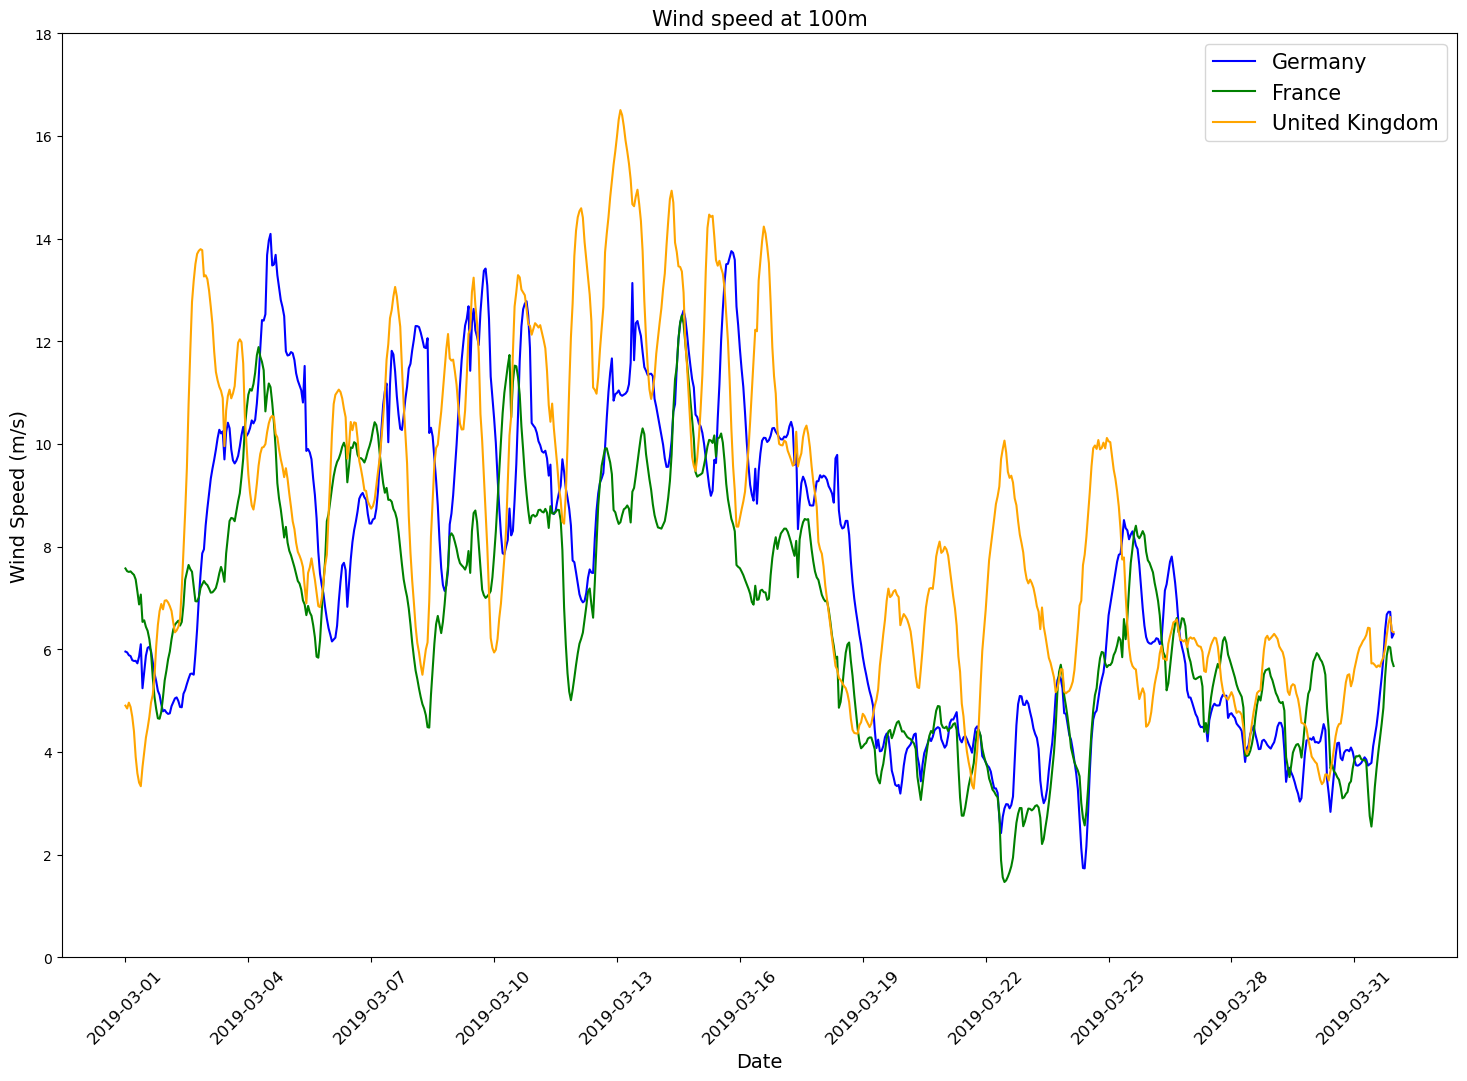

In [7]:
# create the cosine weight of latitudes
weigths = np.cos(np.deg2rad(ds.latitude))
# create mask of countries based on the data latitude and longitude
countries_masked = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(ds, lon_name='longitude', lat_name='latitude')

countries_name = ['Germany', 'France', 'United Kingdom']
colors = ['blue', 'green', 'orange']

fig, ax = plt.subplots(figsize=(18, 12))
for ii, i in enumerate(countries_name):
    # select different countries
    ds_country =ds['ws100'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(i))
    # applied the weighted mean over the country
    wnd100m_country = ds_country.weighted(weigths).mean(dim=('latitude', 'longitude'))
    ax.plot(wnd100m_country, color=colors[ii], label=i)
ax.set_xticks(np.arange(0, len(wnd100m_country.time), 3 * 24))
ax.set_xticklabels(wnd100m_country['time'].values[0: -1: 3 * 24].astype('datetime64[D]'), rotation=45, fontsize=12)
ax.set_ylim([0, 18])
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Wind Speed (m/s)', fontsize=14)
ax.legend(fontsize=15)
plt.title('Wind speed at 100m', fontsize=15)
plt.savefig('wind_speed_100m_countries.png')
